In [48]:
# Creating  CNN model Architecture Using Pytorch 
# Importing all the necessary libraries 

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F
import sys
sys.path.append('../Utils')
import configs
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score, precision_score, classification_report
from torch.utils.data import DataLoader, TensorDataset
from torchvision import datasets, models
from tqdm import tqdm
import time
import copy
import os
import random
import warnings
warnings.filterwarnings("ignore")


In [75]:
# Set UP the model 

class CNNC(nn.Module):
    def __init__(self, num_classes=2):
        super(CNNC, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.fc1 = nn.Linear(32 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, num_classes)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)
        out = self.dropout(self.fc1(out))
        out = self.fc2(out)
        return out



In [76]:
# Create Train AND Evaluate Functions 
def train_model(model, Trainloaders, EvaluateLoader,criterion, optimizer, num_epochs=25):
    train_acc_history = []
    val_acc_history = []
    train_loss_history = []
    val_loss_history = []
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model.to(device)
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
                dataloader = Trainloaders
            else:
                model.eval()   # Set model to evaluate mode
                dataloader = EvaluateLoader

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in tqdm(dataloader):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            epoch_loss = running_loss / len(dataloader.dataset)
            epoch_acc = running_corrects.double() / len(dataloader.dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val':
                val_acc_history.append(epoch_acc)
                val_loss_history.append(epoch_loss)
                if epoch_acc > best_acc:
                    best_acc = epoch_acc
                    best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'train':
                train_acc_history.append(epoch_acc)
                train_loss_history.append(epoch_loss)
    print('Best val Acc: {:4f}'.format(best_acc))
    return model, train_acc_history, val_acc_history, train_loss_history, val_loss_history

def Evaluate(model,TestLoader):
    model.eval()
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model.to(device)
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in tqdm(TestLoader):
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    print("Accuracy:", accuracy_score(all_labels, all_preds))
    print("\nClassification Report",classification_report(all_labels, all_preds))
    return all_labels, all_preds 





In [77]:
# Data loading ,transforming and Augmentation 
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((28, 28)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])
# split train into train and validation

full_dataset = datasets.ImageFolder(configs.MULTIVIEW_TRAIN_DIR, transform=transform)
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(full_dataset, [train_size, val_size])    
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_dataset = datasets.ImageFolder(configs.MULTIVIEW_TRAIN_DIR, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)    
# Initialize the model, criterion and optimizer
model = CNNC(num_classes=7)
criterion = nn.CrossEntropyLoss()   
optimizer = optim.Adam(model.parameters(), lr=0.001)
# Train the model
model, train_acc_history, val_acc_history, train_loss_history, val_loss_history = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=50)
# Evaluate the model    
all_labels, all_preds = Evaluate(model, test_loader)







Epoch 0/49
----------


  0%|          | 0/70 [00:00<?, ?it/s]

100%|██████████| 70/70 [00:07<00:00,  9.47it/s]


train Loss: 1.6991 Acc: 0.3483


100%|██████████| 18/18 [00:01<00:00, 12.83it/s]


val Loss: 1.1948 Acc: 0.5206
Epoch 1/49
----------


100%|██████████| 70/70 [00:06<00:00, 11.17it/s]


train Loss: 1.3407 Acc: 0.4632


100%|██████████| 18/18 [00:01<00:00, 15.88it/s]


val Loss: 1.1738 Acc: 0.4937
Epoch 2/49
----------


100%|██████████| 70/70 [00:05<00:00, 12.56it/s]


train Loss: 1.2562 Acc: 0.4883


100%|██████████| 18/18 [00:01<00:00, 15.22it/s]


val Loss: 1.1770 Acc: 0.5386
Epoch 3/49
----------


100%|██████████| 70/70 [00:06<00:00, 11.41it/s]


train Loss: 1.1668 Acc: 0.5386


100%|██████████| 18/18 [00:01<00:00, 11.23it/s]


val Loss: 1.1025 Acc: 0.5583
Epoch 4/49
----------


100%|██████████| 70/70 [00:06<00:00, 11.10it/s]


train Loss: 1.1074 Acc: 0.5530


100%|██████████| 18/18 [00:01<00:00, 14.14it/s]


val Loss: 1.0835 Acc: 0.5799
Epoch 5/49
----------


100%|██████████| 70/70 [00:06<00:00, 11.21it/s]


train Loss: 1.0772 Acc: 0.5750


100%|██████████| 18/18 [00:00<00:00, 23.59it/s]


val Loss: 1.1131 Acc: 0.5745
Epoch 6/49
----------


100%|██████████| 70/70 [00:03<00:00, 20.64it/s]


train Loss: 1.0213 Acc: 0.5929


100%|██████████| 18/18 [00:00<00:00, 24.85it/s]


val Loss: 1.0722 Acc: 0.5709
Epoch 7/49
----------


100%|██████████| 70/70 [00:03<00:00, 20.88it/s]


train Loss: 1.0023 Acc: 0.5996


100%|██████████| 18/18 [00:00<00:00, 22.16it/s]


val Loss: 1.0049 Acc: 0.6122
Epoch 8/49
----------


100%|██████████| 70/70 [00:03<00:00, 20.62it/s]


train Loss: 0.9713 Acc: 0.6230


100%|██████████| 18/18 [00:00<00:00, 24.66it/s]


val Loss: 1.1862 Acc: 0.5350
Epoch 9/49
----------


100%|██████████| 70/70 [00:03<00:00, 20.73it/s]


train Loss: 0.9399 Acc: 0.6212


100%|██████████| 18/18 [00:00<00:00, 24.22it/s]


val Loss: 0.9825 Acc: 0.5835
Epoch 10/49
----------


100%|██████████| 70/70 [00:03<00:00, 20.38it/s]


train Loss: 0.8893 Acc: 0.6468


100%|██████████| 18/18 [00:00<00:00, 24.64it/s]


val Loss: 0.9917 Acc: 0.6158
Epoch 11/49
----------


100%|██████████| 70/70 [00:03<00:00, 20.71it/s]


train Loss: 0.8675 Acc: 0.6539


100%|██████████| 18/18 [00:00<00:00, 24.08it/s]


val Loss: 1.1881 Acc: 0.5458
Epoch 12/49
----------


100%|██████████| 70/70 [00:05<00:00, 12.47it/s]


train Loss: 0.8014 Acc: 0.6822


100%|██████████| 18/18 [00:01<00:00, 14.37it/s]


val Loss: 1.1259 Acc: 0.5601
Epoch 13/49
----------


100%|██████████| 70/70 [00:05<00:00, 11.91it/s]


train Loss: 0.8061 Acc: 0.6768


100%|██████████| 18/18 [00:01<00:00, 17.88it/s]


val Loss: 1.1041 Acc: 0.5727
Epoch 14/49
----------


100%|██████████| 70/70 [00:03<00:00, 19.14it/s]


train Loss: 0.7428 Acc: 0.7110


100%|██████████| 18/18 [00:00<00:00, 23.52it/s]


val Loss: 1.0276 Acc: 0.6176
Epoch 15/49
----------


100%|██████████| 70/70 [00:03<00:00, 19.81it/s]


train Loss: 0.7256 Acc: 0.7127


100%|██████████| 18/18 [00:00<00:00, 23.27it/s]


val Loss: 1.0284 Acc: 0.6284
Epoch 16/49
----------


100%|██████████| 70/70 [00:03<00:00, 19.43it/s]


train Loss: 0.6777 Acc: 0.7307


100%|██████████| 18/18 [00:00<00:00, 23.55it/s]


val Loss: 1.3324 Acc: 0.5350
Epoch 17/49
----------


100%|██████████| 70/70 [00:03<00:00, 20.35it/s]


train Loss: 0.7282 Acc: 0.7141


100%|██████████| 18/18 [00:00<00:00, 23.93it/s]


val Loss: 1.1524 Acc: 0.5889
Epoch 18/49
----------


100%|██████████| 70/70 [00:03<00:00, 19.87it/s]


train Loss: 0.6540 Acc: 0.7460


100%|██████████| 18/18 [00:00<00:00, 24.25it/s]


val Loss: 1.1257 Acc: 0.5907
Epoch 19/49
----------


100%|██████████| 70/70 [00:03<00:00, 20.15it/s]


train Loss: 0.6159 Acc: 0.7666


100%|██████████| 18/18 [00:00<00:00, 24.36it/s]


val Loss: 1.1430 Acc: 0.6014
Epoch 20/49
----------


100%|██████████| 70/70 [00:05<00:00, 13.17it/s]


train Loss: 0.5964 Acc: 0.7617


100%|██████████| 18/18 [00:01<00:00, 14.74it/s]


val Loss: 1.1243 Acc: 0.6104
Epoch 21/49
----------


100%|██████████| 70/70 [00:05<00:00, 11.82it/s]


train Loss: 0.5731 Acc: 0.7603


100%|██████████| 18/18 [00:01<00:00, 14.65it/s]


val Loss: 1.4377 Acc: 0.5296
Epoch 22/49
----------


100%|██████████| 70/70 [00:05<00:00, 11.92it/s]


train Loss: 0.5560 Acc: 0.7783


100%|██████████| 18/18 [00:01<00:00, 14.45it/s]


val Loss: 1.2331 Acc: 0.5727
Epoch 23/49
----------


100%|██████████| 70/70 [00:05<00:00, 11.68it/s]


train Loss: 0.5344 Acc: 0.7890


100%|██████████| 18/18 [00:01<00:00, 14.81it/s]


val Loss: 1.2480 Acc: 0.5817
Epoch 24/49
----------


100%|██████████| 70/70 [00:05<00:00, 11.90it/s]


train Loss: 0.4870 Acc: 0.8151


100%|██████████| 18/18 [00:01<00:00, 14.95it/s]


val Loss: 1.2354 Acc: 0.5853
Epoch 25/49
----------


100%|██████████| 70/70 [00:06<00:00, 11.64it/s]


train Loss: 0.4647 Acc: 0.8169


100%|██████████| 18/18 [00:01<00:00, 13.80it/s]


val Loss: 1.2285 Acc: 0.5925
Epoch 26/49
----------


100%|██████████| 70/70 [00:05<00:00, 11.85it/s]


train Loss: 0.4815 Acc: 0.8043


100%|██████████| 18/18 [00:01<00:00, 13.70it/s]


val Loss: 1.4135 Acc: 0.5709
Epoch 27/49
----------


100%|██████████| 70/70 [00:04<00:00, 15.59it/s]


train Loss: 0.5009 Acc: 0.8003


100%|██████████| 18/18 [00:00<00:00, 24.03it/s]


val Loss: 1.5526 Acc: 0.5476
Epoch 28/49
----------


100%|██████████| 70/70 [00:03<00:00, 20.34it/s]


train Loss: 0.4421 Acc: 0.8348


100%|██████████| 18/18 [00:00<00:00, 21.35it/s]


val Loss: 1.4264 Acc: 0.5601
Epoch 29/49
----------


100%|██████████| 70/70 [00:03<00:00, 20.33it/s]


train Loss: 0.4082 Acc: 0.8344


100%|██████████| 18/18 [00:00<00:00, 23.50it/s]


val Loss: 1.3041 Acc: 0.5943
Epoch 30/49
----------


100%|██████████| 70/70 [00:03<00:00, 20.08it/s]


train Loss: 0.3904 Acc: 0.8429


100%|██████████| 18/18 [00:00<00:00, 21.84it/s]


val Loss: 1.7241 Acc: 0.5601
Epoch 31/49
----------


100%|██████████| 70/70 [00:03<00:00, 20.09it/s]


train Loss: 0.3530 Acc: 0.8685


100%|██████████| 18/18 [00:00<00:00, 24.33it/s]


val Loss: 1.5156 Acc: 0.5476
Epoch 32/49
----------


100%|██████████| 70/70 [00:03<00:00, 20.61it/s]


train Loss: 0.3818 Acc: 0.8573


100%|██████████| 18/18 [00:00<00:00, 22.54it/s]


val Loss: 1.6707 Acc: 0.5296
Epoch 33/49
----------


100%|██████████| 70/70 [00:04<00:00, 15.97it/s]


train Loss: 0.3242 Acc: 0.8770


100%|██████████| 18/18 [00:01<00:00, 14.96it/s]


val Loss: 1.8215 Acc: 0.5117
Epoch 34/49
----------


100%|██████████| 70/70 [00:05<00:00, 11.79it/s]


train Loss: 0.3240 Acc: 0.8748


100%|██████████| 18/18 [00:01<00:00, 15.94it/s]


val Loss: 1.6286 Acc: 0.5619
Epoch 35/49
----------


100%|██████████| 70/70 [00:04<00:00, 16.47it/s]


train Loss: 0.3073 Acc: 0.8802


100%|██████████| 18/18 [00:00<00:00, 24.41it/s]


val Loss: 1.6684 Acc: 0.5601
Epoch 36/49
----------


100%|██████████| 70/70 [00:03<00:00, 19.99it/s]


train Loss: 0.3339 Acc: 0.8680


100%|██████████| 18/18 [00:00<00:00, 23.42it/s]


val Loss: 1.6564 Acc: 0.5673
Epoch 37/49
----------


100%|██████████| 70/70 [00:03<00:00, 20.51it/s]


train Loss: 0.3058 Acc: 0.8887


100%|██████████| 18/18 [00:00<00:00, 24.02it/s]


val Loss: 1.6854 Acc: 0.5673
Epoch 38/49
----------


100%|██████████| 70/70 [00:03<00:00, 19.59it/s]


train Loss: 0.2680 Acc: 0.9048


100%|██████████| 18/18 [00:00<00:00, 23.88it/s]


val Loss: 1.7046 Acc: 0.5566
Epoch 39/49
----------


100%|██████████| 70/70 [00:03<00:00, 20.44it/s]


train Loss: 0.2471 Acc: 0.9089


100%|██████████| 18/18 [00:00<00:00, 24.41it/s]


val Loss: 1.7884 Acc: 0.5601
Epoch 40/49
----------


100%|██████████| 70/70 [00:03<00:00, 19.95it/s]


train Loss: 0.2268 Acc: 0.9174


100%|██████████| 18/18 [00:00<00:00, 22.98it/s]


val Loss: 2.4862 Acc: 0.5045
Epoch 41/49
----------


100%|██████████| 70/70 [00:04<00:00, 16.93it/s]


train Loss: 0.2500 Acc: 0.9039


100%|██████████| 18/18 [00:01<00:00, 14.26it/s]


val Loss: 1.8146 Acc: 0.5619
Epoch 42/49
----------


100%|██████████| 70/70 [00:06<00:00, 11.61it/s]


train Loss: 0.2423 Acc: 0.9134


100%|██████████| 18/18 [00:01<00:00, 14.77it/s]


val Loss: 1.9926 Acc: 0.5440
Epoch 43/49
----------


100%|██████████| 70/70 [00:05<00:00, 11.67it/s]


train Loss: 0.2242 Acc: 0.9174


100%|██████████| 18/18 [00:01<00:00, 14.78it/s]


val Loss: 2.2648 Acc: 0.5135
Epoch 44/49
----------


100%|██████████| 70/70 [00:06<00:00, 11.51it/s]


train Loss: 0.2378 Acc: 0.9107


100%|██████████| 18/18 [00:01<00:00, 14.69it/s]


val Loss: 2.0964 Acc: 0.5566
Epoch 45/49
----------


100%|██████████| 70/70 [00:05<00:00, 11.84it/s]


train Loss: 0.2026 Acc: 0.9295


100%|██████████| 18/18 [00:01<00:00, 14.05it/s]


val Loss: 1.9157 Acc: 0.5781
Epoch 46/49
----------


100%|██████████| 70/70 [00:05<00:00, 11.95it/s]


train Loss: 0.1956 Acc: 0.9345


100%|██████████| 18/18 [00:01<00:00, 13.26it/s]


val Loss: 1.9801 Acc: 0.5619
Epoch 47/49
----------


100%|██████████| 70/70 [00:06<00:00, 10.75it/s]


train Loss: 0.1421 Acc: 0.9497


100%|██████████| 18/18 [00:01<00:00, 14.15it/s]


val Loss: 2.1411 Acc: 0.5637
Epoch 48/49
----------


100%|██████████| 70/70 [00:05<00:00, 12.07it/s]


train Loss: 0.1566 Acc: 0.9421


100%|██████████| 18/18 [00:00<00:00, 21.38it/s]


val Loss: 3.0270 Acc: 0.4883
Epoch 49/49
----------


100%|██████████| 70/70 [00:03<00:00, 18.71it/s]


train Loss: 0.1809 Acc: 0.9318


100%|██████████| 18/18 [00:00<00:00, 22.46it/s]


val Loss: 2.1658 Acc: 0.5655
Best val Acc: 0.628366


100%|██████████| 88/88 [00:03<00:00, 22.35it/s]

Accuracy: 0.881508078994614

Classification Report               precision    recall  f1-score   support

           0       0.93      0.67      0.78       160
           1       0.82      0.96      0.88       660
           2       0.90      0.90      0.90       735
           3       0.90      0.89      0.89        90
           4       0.89      0.78      0.83       100
           5       0.92      0.86      0.89       405
           6       0.91      0.86      0.88       635

    accuracy                           0.88      2785
   macro avg       0.89      0.85      0.87      2785
weighted avg       0.89      0.88      0.88      2785



In [78]:
# Print all model evaluation metrics 
print("Accuracy:", accuracy_score(all_labels, all_preds))
print("Balanced Accuracy:", balanced_accuracy_score(all_labels, all_preds))
print("F1 Score:", f1_score(all_labels, all_preds, average='weighted'))
print("Precision:", precision_score(all_labels, all_preds, average='weighted'))


Accuracy: 0.881508078994614
Balanced Accuracy: 0.8456216919944891
F1 Score: 0.8805885332270458
Precision: 0.8855608412900439


In [79]:
# calculate models parameters 
import utils as ut 
params = ut.count_dl_parameters(model) 
print(f"Total Parameters: {params['total_params']}")
print(f"Trainable Parameters: {params['trainable_params']}")

Total Parameters: 206631
Trainable Parameters: 206631


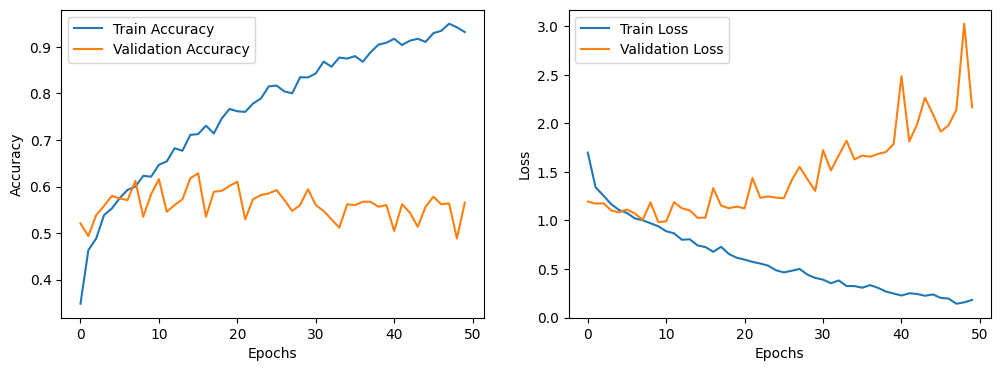

In [80]:

# plot training and validation accuracy and loss 
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_acc_history, label='Train Accuracy')
plt.plot(val_acc_history, label='Validation Accuracy')
plt.xlabel('Epochs')    
plt.ylabel('Accuracy')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(train_loss_history, label='Train Loss')
plt.plot(val_loss_history, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()






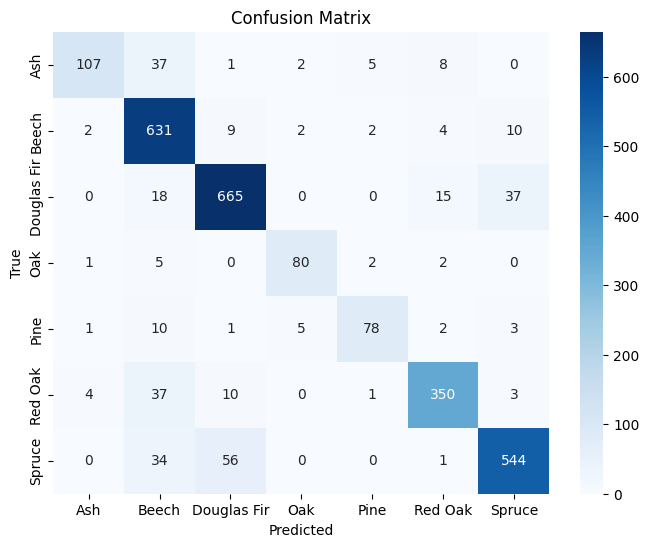

In [82]:
# plot confusion matrix 
import seaborn as sns
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=full_dataset.classes, yticklabels=full_dataset.classes)
plt.xlabel('Predicted') 
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


##### CNN optimization

Epoch 0/99
----------


  0%|          | 0/70 [00:00<?, ?it/s]

100%|██████████| 70/70 [00:07<00:00,  9.45it/s]


train Loss: 1.7250 Acc: 0.3339


100%|██████████| 18/18 [00:01<00:00, 12.65it/s]


val Loss: 1.5518 Acc: 0.3734
Epoch 1/99
----------


100%|██████████| 70/70 [00:06<00:00, 10.71it/s]


train Loss: 1.4289 Acc: 0.4152


100%|██████████| 18/18 [00:01<00:00, 13.07it/s]


val Loss: 1.2674 Acc: 0.4955
Epoch 2/99
----------


100%|██████████| 70/70 [00:06<00:00, 10.82it/s]


train Loss: 1.3419 Acc: 0.4448


100%|██████████| 18/18 [00:01<00:00, 13.64it/s]


val Loss: 1.2580 Acc: 0.4865
Epoch 3/99
----------


100%|██████████| 70/70 [00:06<00:00, 10.73it/s]


train Loss: 1.2788 Acc: 0.4717


100%|██████████| 18/18 [00:01<00:00, 13.16it/s]


val Loss: 1.1868 Acc: 0.5242
Epoch 4/99
----------


100%|██████████| 70/70 [00:07<00:00,  8.91it/s]


train Loss: 1.2330 Acc: 0.4955


100%|██████████| 18/18 [00:01<00:00, 10.98it/s]


val Loss: 1.2400 Acc: 0.5063
Epoch 5/99
----------


100%|██████████| 70/70 [00:06<00:00, 11.18it/s]


train Loss: 1.2184 Acc: 0.5009


100%|██████████| 18/18 [00:01<00:00, 13.62it/s]


val Loss: 1.2167 Acc: 0.4955
Epoch 6/99
----------


100%|██████████| 70/70 [00:06<00:00, 11.63it/s]


train Loss: 1.2008 Acc: 0.5000


100%|██████████| 18/18 [00:01<00:00, 13.74it/s]


val Loss: 1.1861 Acc: 0.5278
Epoch 7/99
----------


100%|██████████| 70/70 [00:05<00:00, 11.77it/s]


train Loss: 1.1699 Acc: 0.5256


100%|██████████| 18/18 [00:01<00:00, 13.11it/s]


val Loss: 1.1433 Acc: 0.5601
Epoch 8/99
----------


100%|██████████| 70/70 [00:05<00:00, 11.92it/s]


train Loss: 1.1308 Acc: 0.5417


100%|██████████| 18/18 [00:01<00:00, 13.67it/s]


val Loss: 1.1547 Acc: 0.5296
Epoch 9/99
----------


100%|██████████| 70/70 [00:06<00:00, 11.58it/s]


train Loss: 1.1587 Acc: 0.5287


100%|██████████| 18/18 [00:01<00:00, 13.70it/s]


val Loss: 1.1653 Acc: 0.5260
Epoch 10/99
----------


100%|██████████| 70/70 [00:06<00:00, 11.56it/s]


train Loss: 1.1377 Acc: 0.5373


100%|██████████| 18/18 [00:01<00:00, 10.29it/s]


val Loss: 1.1341 Acc: 0.5368
Epoch 11/99
----------


100%|██████████| 70/70 [00:08<00:00,  8.16it/s]


train Loss: 1.1010 Acc: 0.5364


100%|██████████| 18/18 [00:01<00:00, 10.57it/s]


val Loss: 1.1622 Acc: 0.5548
Epoch 12/99
----------


100%|██████████| 70/70 [00:07<00:00,  9.05it/s]


train Loss: 1.1227 Acc: 0.5296


100%|██████████| 18/18 [00:01<00:00, 13.68it/s]


val Loss: 1.0715 Acc: 0.5655
Epoch 13/99
----------


100%|██████████| 70/70 [00:06<00:00, 11.55it/s]


train Loss: 1.1055 Acc: 0.5480


100%|██████████| 18/18 [00:01<00:00, 12.98it/s]


val Loss: 1.1571 Acc: 0.5224
Epoch 14/99
----------


100%|██████████| 70/70 [00:05<00:00, 11.75it/s]


train Loss: 1.0894 Acc: 0.5539


100%|██████████| 18/18 [00:01<00:00, 13.13it/s]


val Loss: 1.0755 Acc: 0.5601
Epoch 15/99
----------


100%|██████████| 70/70 [00:06<00:00, 11.28it/s]


train Loss: 1.0857 Acc: 0.5539


100%|██████████| 18/18 [00:01<00:00, 13.74it/s]


val Loss: 1.0905 Acc: 0.5655
Epoch 16/99
----------


100%|██████████| 70/70 [00:06<00:00, 11.42it/s]


train Loss: 1.0498 Acc: 0.5848


100%|██████████| 18/18 [00:01<00:00, 13.83it/s]


val Loss: 1.0521 Acc: 0.5673
Epoch 17/99
----------


100%|██████████| 70/70 [00:06<00:00, 11.65it/s]


train Loss: 1.0502 Acc: 0.5763


100%|██████████| 18/18 [00:01<00:00, 13.64it/s]


val Loss: 1.0373 Acc: 0.6014
Epoch 18/99
----------


100%|██████████| 70/70 [00:07<00:00,  9.02it/s]


train Loss: 1.0591 Acc: 0.5678


100%|██████████| 18/18 [00:01<00:00, 10.48it/s]


val Loss: 1.1280 Acc: 0.5727
Epoch 19/99
----------


100%|██████████| 70/70 [00:08<00:00,  8.28it/s]


train Loss: 1.0586 Acc: 0.5660


100%|██████████| 18/18 [00:01<00:00, 10.26it/s]


val Loss: 1.0826 Acc: 0.5817
Epoch 20/99
----------


100%|██████████| 70/70 [00:08<00:00,  8.11it/s]


train Loss: 1.0290 Acc: 0.5790


100%|██████████| 18/18 [00:01<00:00,  9.80it/s]


val Loss: 1.1969 Acc: 0.5260
Epoch 21/99
----------


100%|██████████| 70/70 [00:08<00:00,  8.37it/s]


train Loss: 1.0187 Acc: 0.5911


100%|██████████| 18/18 [00:01<00:00, 10.04it/s]


val Loss: 1.1718 Acc: 0.5386
Epoch 22/99
----------


100%|██████████| 70/70 [00:08<00:00,  7.98it/s]


train Loss: 1.0622 Acc: 0.5750


100%|██████████| 18/18 [00:01<00:00, 10.42it/s]


val Loss: 1.1978 Acc: 0.5153
Epoch 23/99
----------


100%|██████████| 70/70 [00:08<00:00,  8.34it/s]


train Loss: 1.0377 Acc: 0.5803


100%|██████████| 18/18 [00:01<00:00,  9.76it/s]


val Loss: 1.0747 Acc: 0.6050
Epoch 24/99
----------


100%|██████████| 70/70 [00:08<00:00,  8.57it/s]


train Loss: 0.9973 Acc: 0.5853


100%|██████████| 18/18 [00:01<00:00, 10.73it/s]


val Loss: 1.1328 Acc: 0.5978
Epoch 25/99
----------


100%|██████████| 70/70 [00:07<00:00,  9.88it/s]


train Loss: 1.0024 Acc: 0.5839


100%|██████████| 18/18 [00:01<00:00, 12.48it/s]


val Loss: 1.1326 Acc: 0.5601
Epoch 26/99
----------


100%|██████████| 70/70 [00:06<00:00, 11.41it/s]


train Loss: 0.9906 Acc: 0.6046


100%|██████████| 18/18 [00:01<00:00, 13.17it/s]


val Loss: 1.1773 Acc: 0.5260
Epoch 27/99
----------


100%|██████████| 70/70 [00:06<00:00, 11.32it/s]


train Loss: 0.9959 Acc: 0.5965


100%|██████████| 18/18 [00:01<00:00, 13.36it/s]


val Loss: 1.0179 Acc: 0.6032
Epoch 28/99
----------


100%|██████████| 70/70 [00:06<00:00, 11.51it/s]


train Loss: 0.9979 Acc: 0.5965


100%|██████████| 18/18 [00:01<00:00, 13.30it/s]


val Loss: 1.0424 Acc: 0.6050
Epoch 29/99
----------


100%|██████████| 70/70 [00:06<00:00, 11.36it/s]


train Loss: 0.9472 Acc: 0.6154


100%|██████████| 18/18 [00:01<00:00, 13.35it/s]


val Loss: 1.0601 Acc: 0.5763
Epoch 30/99
----------


100%|██████████| 70/70 [00:06<00:00, 11.39it/s]


train Loss: 0.9819 Acc: 0.5965


100%|██████████| 18/18 [00:01<00:00, 12.76it/s]


val Loss: 1.0343 Acc: 0.6014
Epoch 31/99
----------


100%|██████████| 70/70 [00:07<00:00,  9.19it/s]


train Loss: 0.9552 Acc: 0.6118


100%|██████████| 18/18 [00:01<00:00, 10.42it/s]


val Loss: 1.1366 Acc: 0.5476
Epoch 32/99
----------


100%|██████████| 70/70 [00:08<00:00,  8.56it/s]


train Loss: 0.9454 Acc: 0.6239


100%|██████████| 18/18 [00:01<00:00, 10.66it/s]


val Loss: 1.0303 Acc: 0.5871
Epoch 33/99
----------


100%|██████████| 70/70 [00:06<00:00, 11.00it/s]


train Loss: 0.9595 Acc: 0.6113


100%|██████████| 18/18 [00:01<00:00, 13.52it/s]


val Loss: 1.0363 Acc: 0.5943
Epoch 34/99
----------


100%|██████████| 70/70 [00:06<00:00, 11.46it/s]


train Loss: 0.9641 Acc: 0.6176


100%|██████████| 18/18 [00:01<00:00, 12.40it/s]


val Loss: 1.0267 Acc: 0.5907
Epoch 35/99
----------


100%|██████████| 70/70 [00:06<00:00, 11.04it/s]


train Loss: 0.9471 Acc: 0.6131


100%|██████████| 18/18 [00:01<00:00, 13.43it/s]


val Loss: 0.9957 Acc: 0.6302
Epoch 36/99
----------


100%|██████████| 70/70 [00:06<00:00, 11.50it/s]


train Loss: 0.9383 Acc: 0.6216


100%|██████████| 18/18 [00:01<00:00, 12.72it/s]


val Loss: 1.0188 Acc: 0.6122
Epoch 37/99
----------


100%|██████████| 70/70 [00:06<00:00, 11.32it/s]


train Loss: 0.9451 Acc: 0.6297


100%|██████████| 18/18 [00:01<00:00, 13.04it/s]


val Loss: 1.0811 Acc: 0.5727
Epoch 38/99
----------


100%|██████████| 70/70 [00:06<00:00, 11.50it/s]


train Loss: 0.9163 Acc: 0.6382


100%|██████████| 18/18 [00:01<00:00,  9.70it/s]


val Loss: 1.0029 Acc: 0.6230
Epoch 39/99
----------


100%|██████████| 70/70 [00:08<00:00,  8.40it/s]


train Loss: 0.9052 Acc: 0.6311


100%|██████████| 18/18 [00:01<00:00, 10.41it/s]


val Loss: 1.0148 Acc: 0.5853
Epoch 40/99
----------


100%|██████████| 70/70 [00:08<00:00,  8.37it/s]


train Loss: 0.9256 Acc: 0.6315


100%|██████████| 18/18 [00:01<00:00, 10.02it/s]


val Loss: 1.0376 Acc: 0.6014
Epoch 41/99
----------


100%|██████████| 70/70 [00:08<00:00,  8.20it/s]


train Loss: 0.9158 Acc: 0.6216


100%|██████████| 18/18 [00:01<00:00, 10.42it/s]


val Loss: 0.9586 Acc: 0.6302
Epoch 42/99
----------


100%|██████████| 70/70 [00:08<00:00,  8.40it/s]


train Loss: 0.9261 Acc: 0.6293


100%|██████████| 18/18 [00:01<00:00, 10.26it/s]


val Loss: 0.9753 Acc: 0.6140
Epoch 43/99
----------


100%|██████████| 70/70 [00:08<00:00,  8.36it/s]


train Loss: 0.9161 Acc: 0.6346


100%|██████████| 18/18 [00:01<00:00, 10.57it/s]


val Loss: 1.0042 Acc: 0.6032
Epoch 44/99
----------


100%|██████████| 70/70 [00:08<00:00,  8.49it/s]


train Loss: 0.8966 Acc: 0.6333


100%|██████████| 18/18 [00:01<00:00, 10.57it/s]


val Loss: 1.0094 Acc: 0.6158
Epoch 45/99
----------


100%|██████████| 70/70 [00:08<00:00,  8.62it/s]


train Loss: 0.8793 Acc: 0.6477


100%|██████████| 18/18 [00:01<00:00, 10.79it/s]


val Loss: 0.9853 Acc: 0.6427
Epoch 46/99
----------


100%|██████████| 70/70 [00:06<00:00, 11.37it/s]


train Loss: 0.8932 Acc: 0.6499


100%|██████████| 18/18 [00:01<00:00, 14.05it/s]


val Loss: 0.9775 Acc: 0.5996
Epoch 47/99
----------


100%|██████████| 70/70 [00:06<00:00, 11.58it/s]


train Loss: 0.8764 Acc: 0.6490


100%|██████████| 18/18 [00:01<00:00, 12.98it/s]


val Loss: 0.9942 Acc: 0.5907
Epoch 48/99
----------


100%|██████████| 70/70 [00:06<00:00, 11.66it/s]


train Loss: 0.8829 Acc: 0.6405


100%|██████████| 18/18 [00:01<00:00, 13.64it/s]


val Loss: 1.0431 Acc: 0.6014
Epoch 49/99
----------


100%|██████████| 70/70 [00:06<00:00, 11.19it/s]


train Loss: 0.8728 Acc: 0.6495


100%|██████████| 18/18 [00:01<00:00, 12.49it/s]


val Loss: 1.0665 Acc: 0.6284
Epoch 50/99
----------


100%|██████████| 70/70 [00:05<00:00, 11.81it/s]


train Loss: 0.8812 Acc: 0.6391


100%|██████████| 18/18 [00:01<00:00, 13.50it/s]


val Loss: 1.0981 Acc: 0.5996
Epoch 51/99
----------


100%|██████████| 70/70 [00:06<00:00, 11.57it/s]


train Loss: 0.8667 Acc: 0.6495


100%|██████████| 18/18 [00:01<00:00,  9.99it/s]


val Loss: 1.0063 Acc: 0.6230
Early stopping at epoch 51
Best val Acc: 0.000000


100%|██████████| 21/21 [00:02<00:00,  8.74it/s]


Accuracy: 0.6626865671641791
Balanced Accuracy: 0.5696004460074918
F1 Score: 0.6529602850084859
Precision: 0.6695006261833778

Classification Report:
               precision    recall  f1-score   support

           0       0.54      0.40      0.46        35
           1       0.72      0.77      0.74       160
           2       0.64      0.82      0.72       180
           3       0.55      0.30      0.39        20
           4       0.68      0.52      0.59        25
           5       0.59      0.71      0.64        95
           6       0.74      0.47      0.58       155

    accuracy                           0.66       670
   macro avg       0.64      0.57      0.59       670
weighted avg       0.67      0.66      0.65       670



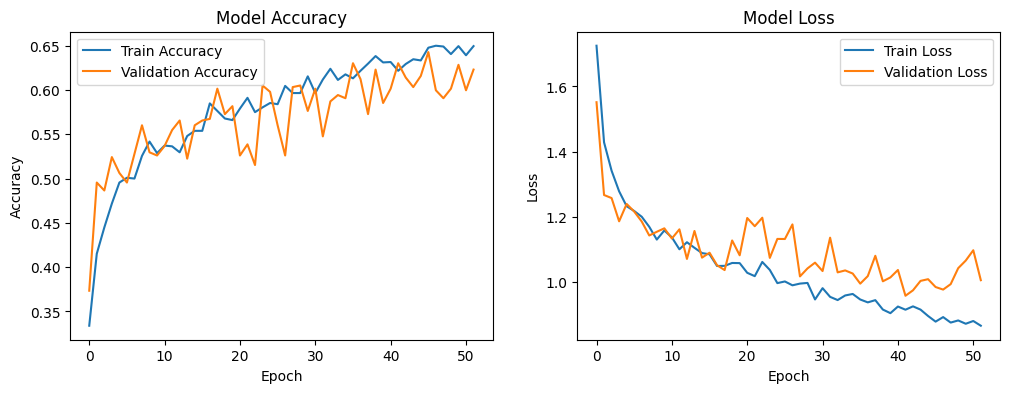

Total Parameters: 206631


In [83]:
# Creating CNN model Architecture Using Pytorch 
# Importing all the necessary libraries 

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F
import sys
sys.path.append('../Utils')
import configs
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score, precision_score, classification_report
from torch.utils.data import DataLoader, TensorDataset
from torchvision import datasets, models
from tqdm import tqdm
import time
import copy
import os
import random
import warnings
warnings.filterwarnings("ignore")

# Set UP the model 

class CNNC(nn.Module):
    def __init__(self, num_classes=2):
        super(CNNC, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.fc1 = nn.Linear(32 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, num_classes)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)
        out = self.dropout(self.fc1(out))
        out = self.fc2(out)
        return out

# Create Train AND Evaluate Functions 
def train_model(model, Trainloaders, EvaluateLoader, criterion, optimizer, scheduler, num_epochs=25, patience=5):
    train_acc_history = []
    val_acc_history = []
    train_loss_history = []
    val_loss_history = []
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    best_loss = float('inf')
    patience_counter = 0
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model.to(device)
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
                dataloader = Trainloaders
            else:
                model.eval()   # Set model to evaluate mode
                dataloader = EvaluateLoader

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in tqdm(dataloader):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            
            epoch_loss = running_loss / len(dataloader.dataset)
            epoch_acc = running_corrects.double() / len(dataloader.dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val':
                val_acc_history.append(epoch_acc)
                val_loss_history.append(epoch_loss)
                scheduler.step(epoch_loss)
                if epoch_loss < best_loss:
                    best_loss = epoch_loss
                    best_model_wts = copy.deepcopy(model.state_dict())
                    patience_counter = 0
                else:
                    patience_counter += 1
            if phase == 'train':
                train_acc_history.append(epoch_acc)
                train_loss_history.append(epoch_loss)
        
        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch}")
            break
    
    print('Best val Acc: {:4f}'.format(best_acc))
    model.load_state_dict(best_model_wts)
    return model, train_acc_history, val_acc_history, train_loss_history, val_loss_history

def Evaluate(model, TestLoader):
    model.eval()
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model.to(device)
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in tqdm(TestLoader):
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    print("Accuracy:", accuracy_score(all_labels, all_preds))
    print("Balanced Accuracy:", balanced_accuracy_score(all_labels, all_preds))
    print("F1 Score:", f1_score(all_labels, all_preds, average='weighted'))
    print("Precision:", precision_score(all_labels, all_preds, average='weighted'))
    print("\nClassification Report:\n", classification_report(all_labels, all_preds))
    return all_labels, all_preds

# Data loading ,transforming and Augmentation 
transform_train = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((28, 28)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

transform_test = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((28, 28)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load datasets
train_dataset = datasets.ImageFolder(configs.MULTIVIEW_TRAIN_DIR, transform=transform_train)
test_dataset = datasets.ImageFolder(configs.MULTIVIEW_TEST_DIR, transform=transform_test)

# Split train into train and validation
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_subset, val_subset = torch.utils.data.random_split(train_dataset, [train_size, val_size])

train_loader = DataLoader(train_subset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_subset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Initialize the model, criterion and optimizer
model = CNNC(num_classes=7)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10)

# Train the model
model, train_acc_history, val_acc_history, train_loss_history, val_loss_history = train_model(
    model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=100, patience=10
)

# Evaluate the model
all_labels, all_preds = Evaluate(model, test_loader)

# Plot training and validation accuracy and loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_acc_history, label='Train Accuracy')
plt.plot(val_acc_history, label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_loss_history, label='Train Loss')
plt.plot(val_loss_history, label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Calculate model parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

total_params = count_parameters(model)
print(f"Total Parameters: {total_params}")

⚖️  Class Weights: tensor([2.4866, 0.5883, 0.5516, 4.3012, 4.0289, 0.9793, 0.6315])
🚀 Starting Training...
Epoch 0/99
----------


Train Epoch 0: 100%|██████████| 70/70 [10:26<00:00,  8.95s/it]


train Loss: 2.2230 Acc: 0.1360


Val Epoch 0: 100%|██████████| 18/18 [01:06<00:00,  3.71s/it]


val Loss: 1.9499 Acc: 0.0575
✅ New best accuracy: 0.0575
Epoch 1/99
----------


Train Epoch 1: 100%|██████████| 70/70 [10:21<00:00,  8.88s/it]


train Loss: 1.9739 Acc: 0.1661


Val Epoch 1: 100%|██████████| 18/18 [01:18<00:00,  4.36s/it]


val Loss: 1.9438 Acc: 0.0575
Epoch 2/99
----------


Train Epoch 2: 100%|██████████| 70/70 [10:24<00:00,  8.92s/it]


train Loss: 1.9677 Acc: 0.1293


Val Epoch 2: 100%|██████████| 18/18 [01:20<00:00,  4.45s/it]


val Loss: 1.9462 Acc: 0.0287
Epoch 3/99
----------


Train Epoch 3: 100%|██████████| 70/70 [10:25<00:00,  8.93s/it]


train Loss: 1.9551 Acc: 0.0884


Val Epoch 3: 100%|██████████| 18/18 [01:09<00:00,  3.86s/it]


val Loss: 1.9460 Acc: 0.1436
✅ New best accuracy: 0.1436
Epoch 4/99
----------


Train Epoch 4: 100%|██████████| 70/70 [10:41<00:00,  9.17s/it] 


train Loss: 1.9554 Acc: 0.1275


Val Epoch 4: 100%|██████████| 18/18 [01:13<00:00,  4.10s/it]


val Loss: 1.9489 Acc: 0.1436
Epoch 5/99
----------


Train Epoch 5: 100%|██████████| 70/70 [08:06<00:00,  6.95s/it]


train Loss: 1.9470 Acc: 0.2114


Val Epoch 5: 100%|██████████| 18/18 [00:53<00:00,  2.96s/it]


val Loss: 1.9456 Acc: 0.2136
✅ New best accuracy: 0.2136
Epoch 6/99
----------


Train Epoch 6: 100%|██████████| 70/70 [08:37<00:00,  7.39s/it]


train Loss: 1.9527 Acc: 0.2127


Val Epoch 6: 100%|██████████| 18/18 [00:54<00:00,  3.03s/it]


val Loss: 1.9454 Acc: 0.1293
Epoch 7/99
----------


Train Epoch 7: 100%|██████████| 70/70 [08:35<00:00,  7.37s/it]


train Loss: 1.9583 Acc: 0.1925


Val Epoch 7: 100%|██████████| 18/18 [00:58<00:00,  3.26s/it]


val Loss: 1.9455 Acc: 0.2136
Epoch 8/99
----------


Train Epoch 8: 100%|██████████| 70/70 [08:41<00:00,  7.45s/it]


train Loss: 1.9460 Acc: 0.2410


Val Epoch 8: 100%|██████████| 18/18 [00:59<00:00,  3.30s/it]


val Loss: 1.9453 Acc: 0.2136
Epoch 9/99
----------


Train Epoch 9: 100%|██████████| 70/70 [08:41<00:00,  7.44s/it]


train Loss: 1.9452 Acc: 0.2433


Val Epoch 9: 100%|██████████| 18/18 [00:58<00:00,  3.27s/it]


val Loss: 1.9451 Acc: 0.2136
Epoch 10/99
----------


Train Epoch 10: 100%|██████████| 70/70 [08:38<00:00,  7.41s/it]


train Loss: 1.9456 Acc: 0.2361


Val Epoch 10: 100%|██████████| 18/18 [00:59<00:00,  3.31s/it]


val Loss: 1.9449 Acc: 0.2136
Epoch 11/99
----------


Train Epoch 11: 100%|██████████| 70/70 [08:39<00:00,  7.42s/it]


train Loss: 1.9468 Acc: 0.2231


Val Epoch 11: 100%|██████████| 18/18 [00:58<00:00,  3.23s/it]


val Loss: 1.9598 Acc: 0.2136
Epoch 12/99
----------


Train Epoch 12: 100%|██████████| 70/70 [08:42<00:00,  7.46s/it]


train Loss: 1.9506 Acc: 0.2325


Val Epoch 12: 100%|██████████| 18/18 [00:59<00:00,  3.29s/it]


val Loss: 1.9446 Acc: 0.2136
Epoch 13/99
----------


Train Epoch 13: 100%|██████████| 70/70 [08:39<00:00,  7.42s/it]


train Loss: 1.9472 Acc: 0.2370


Val Epoch 13: 100%|██████████| 18/18 [00:59<00:00,  3.31s/it]


val Loss: 1.9447 Acc: 0.2136
Epoch 14/99
----------


Train Epoch 14: 100%|██████████| 70/70 [08:39<00:00,  7.42s/it]


train Loss: 1.9459 Acc: 0.2208


Val Epoch 14: 100%|██████████| 18/18 [00:59<00:00,  3.30s/it]


val Loss: 1.9446 Acc: 0.2136
Epoch 15/99
----------


Train Epoch 15: 100%|██████████| 70/70 [08:42<00:00,  7.47s/it]


train Loss: 1.9490 Acc: 0.2163


Val Epoch 15: 100%|██████████| 18/18 [01:04<00:00,  3.58s/it]


val Loss: 1.9446 Acc: 0.2136
Epoch 16/99
----------


Train Epoch 16: 100%|██████████| 70/70 [09:40<00:00,  8.29s/it]


train Loss: 1.9455 Acc: 0.2406


Val Epoch 16: 100%|██████████| 18/18 [01:11<00:00,  3.94s/it]


val Loss: 1.9445 Acc: 0.2136
Epoch 17/99
----------


Train Epoch 17: 100%|██████████| 70/70 [09:08<00:00,  7.83s/it]


train Loss: 1.9467 Acc: 0.2383


Val Epoch 17: 100%|██████████| 18/18 [01:04<00:00,  3.56s/it]


val Loss: 1.9433 Acc: 0.2136
Epoch 18/99
----------


Train Epoch 18: 100%|██████████| 70/70 [09:04<00:00,  7.77s/it]


train Loss: 1.9462 Acc: 0.2338


Val Epoch 18: 100%|██████████| 18/18 [01:04<00:00,  3.57s/it]


val Loss: 1.9444 Acc: 0.2136
Epoch 19/99
----------


Train Epoch 19: 100%|██████████| 70/70 [08:08<00:00,  6.98s/it]


train Loss: 1.9470 Acc: 0.2163


Val Epoch 19: 100%|██████████| 18/18 [00:55<00:00,  3.06s/it]


val Loss: 1.9449 Acc: 0.2837
✅ New best accuracy: 0.2837
Epoch 20/99
----------


Train Epoch 20: 100%|██████████| 70/70 [07:30<00:00,  6.43s/it]


train Loss: 1.9469 Acc: 0.2338


Val Epoch 20: 100%|██████████| 18/18 [00:53<00:00,  2.95s/it]


val Loss: 1.9444 Acc: 0.2136
Epoch 21/99
----------


Train Epoch 21: 100%|██████████| 70/70 [08:05<00:00,  6.94s/it]


train Loss: 1.9469 Acc: 0.2316


Val Epoch 21: 100%|██████████| 18/18 [01:10<00:00,  3.93s/it]


val Loss: 1.9443 Acc: 0.2136
Epoch 22/99
----------


Train Epoch 22: 100%|██████████| 70/70 [10:21<00:00,  8.88s/it]


train Loss: 1.9518 Acc: 0.2087


Val Epoch 22: 100%|██████████| 18/18 [01:21<00:00,  4.50s/it]


val Loss: 1.9443 Acc: 0.2136
Epoch 23/99
----------


Train Epoch 23: 100%|██████████| 70/70 [10:28<00:00,  8.98s/it]


train Loss: 1.9487 Acc: 0.2208


Val Epoch 23: 100%|██████████| 18/18 [01:20<00:00,  4.47s/it]


val Loss: 1.9434 Acc: 0.1436
Epoch 24/99
----------


Train Epoch 24: 100%|██████████| 70/70 [10:18<00:00,  8.84s/it]


train Loss: 1.9477 Acc: 0.2343


Val Epoch 24: 100%|██████████| 18/18 [01:15<00:00,  4.19s/it]


val Loss: 1.9444 Acc: 0.2136
Epoch 25/99
----------


Train Epoch 25: 100%|██████████| 70/70 [10:20<00:00,  8.86s/it]


train Loss: 1.9476 Acc: 0.2303


Val Epoch 25: 100%|██████████| 18/18 [01:11<00:00,  3.99s/it]


val Loss: 1.9443 Acc: 0.2136
Epoch 26/99
----------


Train Epoch 26: 100%|██████████| 70/70 [10:30<00:00,  9.00s/it]


train Loss: 1.9459 Acc: 0.2478


Val Epoch 26: 100%|██████████| 18/18 [01:08<00:00,  3.79s/it]


val Loss: 1.9443 Acc: 0.2136
Epoch 27/99
----------


Train Epoch 27: 100%|██████████| 70/70 [10:24<00:00,  8.92s/it]


train Loss: 1.9491 Acc: 0.2401


Val Epoch 27: 100%|██████████| 18/18 [01:09<00:00,  3.87s/it]


val Loss: 1.9443 Acc: 0.2136
Epoch 28/99
----------


Train Epoch 28: 100%|██████████| 70/70 [10:26<00:00,  8.95s/it]


train Loss: 1.9460 Acc: 0.2289


Val Epoch 28: 100%|██████████| 18/18 [01:12<00:00,  4.01s/it]


val Loss: 1.9444 Acc: 0.2136
Epoch 29/99
----------


Train Epoch 29: 100%|██████████| 70/70 [10:16<00:00,  8.80s/it]


train Loss: 1.9463 Acc: 0.2374


Val Epoch 29: 100%|██████████| 18/18 [01:19<00:00,  4.43s/it]


val Loss: 1.9442 Acc: 0.2136
Epoch 30/99
----------


Train Epoch 30: 100%|██████████| 70/70 [10:05<00:00,  8.65s/it]


train Loss: 1.9457 Acc: 0.2379


Val Epoch 30: 100%|██████████| 18/18 [01:16<00:00,  4.24s/it]


val Loss: 1.9442 Acc: 0.2136
Epoch 31/99
----------


Train Epoch 31: 100%|██████████| 70/70 [10:00<00:00,  8.58s/it]


train Loss: 1.9453 Acc: 0.2325


Val Epoch 31: 100%|██████████| 18/18 [01:13<00:00,  4.10s/it]


val Loss: 1.9442 Acc: 0.2136
Epoch 32/99
----------


Train Epoch 32: 100%|██████████| 70/70 [10:09<00:00,  8.70s/it]


train Loss: 1.9449 Acc: 0.2316


Val Epoch 32: 100%|██████████| 18/18 [01:07<00:00,  3.73s/it]


val Loss: 1.9433 Acc: 0.2352
Epoch 33/99
----------


Train Epoch 33: 100%|██████████| 70/70 [10:24<00:00,  8.92s/it]


train Loss: 1.9458 Acc: 0.2258


Val Epoch 33: 100%|██████████| 18/18 [01:37<00:00,  5.39s/it]


val Loss: 1.9444 Acc: 0.2837
Epoch 34/99
----------


Train Epoch 34: 100%|██████████| 70/70 [12:52<00:00, 11.04s/it] 


train Loss: 1.9453 Acc: 0.2307


Val Epoch 34: 100%|██████████| 18/18 [00:47<00:00,  2.62s/it]


val Loss: 1.9443 Acc: 0.2136
🛑 Early stopping at epoch 34
🏆 Best val Acc: 0.283662

🧪 Evaluating on Test Set...


Testing: 100%|██████████| 21/21 [00:41<00:00,  1.97s/it]


🎯 Final Test Accuracy: 0.2687
⚖️  Balanced Accuracy: 0.1429
📊 F1 Score: 0.1138
🔍 Precision: 0.0722

📋 Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        35
           1       0.00      0.00      0.00       160
           2       0.27      1.00      0.42       180
           3       0.00      0.00      0.00        20
           4       0.00      0.00      0.00        25
           5       0.00      0.00      0.00        95
           6       0.00      0.00      0.00       155

    accuracy                           0.27       670
   macro avg       0.04      0.14      0.06       670
weighted avg       0.07      0.27      0.11       670



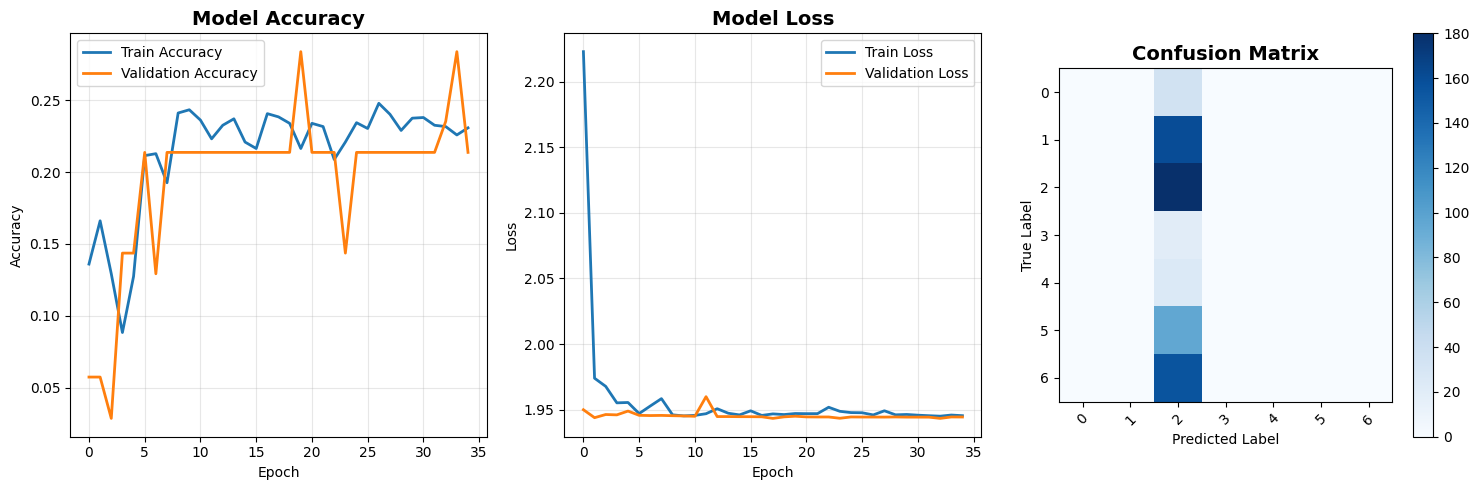

🧮 Total Trainable Parameters: 103,430,727
💾 Model saved as 'best_model_no_pretrained.pth'


In [85]:
# Creating CNN model Architecture Using PyTorch (Improved for 90%+ Accuracy - NO PRETRAINED MODELS)
# Importing all the necessary libraries

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F
import sys
sys.path.append('../Utils')
import configs
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score, precision_score, classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
from torch.utils.data import DataLoader, TensorDataset
from torchvision import datasets
from tqdm import tqdm
import time
import copy
import os
import random
import warnings
warnings.filterwarnings("ignore")

# ----------------------------
# CUSTOM DEEP CNN ARCHITECTURE (NO PRETRAINED MODELS)
# ----------------------------
class DeepCNN(nn.Module):
    def __init__(self, num_classes=7):
        super(DeepCNN, self).__init__()
        
        # Block 1
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Block 2
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1)
        self.bn4 = nn.BatchNorm2d(128)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Block 3
        self.conv5 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        self.bn5 = nn.BatchNorm2d(256)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Fully Connected Layers
        self.fc1 = nn.Linear(256 * 28 * 28, 512)  # Adjusted for 224->28 after 3 pools
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, num_classes)
        
        # Regularization
        self.dropout = nn.Dropout(0.5)
        self.dropout2d = nn.Dropout2d(0.3)
        
        # Initialize weights
        self._initialize_weights()
    
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        # Block 1
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool1(x)
        x = self.dropout2d(x)
        
        # Block 2
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.relu(self.bn4(self.conv4(x)))
        x = self.pool2(x)
        x = self.dropout2d(x)
        
        # Block 3
        x = F.relu(self.bn5(self.conv5(x)))
        x = self.pool3(x)
        x = self.dropout2d(x)
        
        # Flatten
        x = x.view(x.size(0), -1)
        
        # FC Layers
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        
        return x

# ----------------------------
# TRAINING & EVALUATION FUNCTIONS
# ----------------------------
def train_model(model, Trainloaders, EvaluateLoader, criterion, optimizer, scheduler, num_epochs=100, patience=15):
    train_acc_history = []
    val_acc_history = []
    train_loss_history = []
    val_loss_history = []
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    patience_counter = 0
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model.to(device)
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
                dataloader = Trainloaders
            else:
                model.eval()
                dataloader = EvaluateLoader

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in tqdm(dataloader, desc=f"{phase.capitalize()} Epoch {epoch}"):
                inputs = inputs.to(device)
                labels = labels.to(device)
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            
            epoch_loss = running_loss / len(dataloader.dataset)
            epoch_acc = running_corrects.double() / len(dataloader.dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            if phase == 'val':
                val_acc_history.append(epoch_acc)
                val_loss_history.append(epoch_loss)
                scheduler.step(epoch_loss)
                
                if epoch_acc > best_acc:
                    best_acc = epoch_acc
                    best_model_wts = copy.deepcopy(model.state_dict())
                    patience_counter = 0
                    print(f"✅ New best accuracy: {best_acc:.4f}")
                else:
                    patience_counter += 1
                    
            if phase == 'train':
                train_acc_history.append(epoch_acc)
                train_loss_history.append(epoch_loss)
        
        if patience_counter >= patience:
            print(f"🛑 Early stopping at epoch {epoch}")
            break
    
    print('🏆 Best val Acc: {:.6f}'.format(best_acc))
    model.load_state_dict(best_model_wts)
    return model, train_acc_history, val_acc_history, train_loss_history, val_loss_history

def Evaluate(model, TestLoader):
    model.eval()
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model.to(device)
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for inputs, labels in tqdm(TestLoader, desc="Testing"):
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    acc = accuracy_score(all_labels, all_preds)
    bal_acc = balanced_accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='weighted')
    prec = precision_score(all_labels, all_preds, average='weighted')
    
    print(f"🎯 Final Test Accuracy: {acc:.4f}")
    print(f"⚖️  Balanced Accuracy: {bal_acc:.4f}")
    print(f"📊 F1 Score: {f1:.4f}")
    print(f"🔍 Precision: {prec:.4f}")
    print("\n📋 Classification Report:\n", classification_report(all_labels, all_preds))
    
    return all_labels, all_preds

# ----------------------------
# DATA TRANSFORMS & LOADING
# ----------------------------
transform_train = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((224, 224)),  # Larger input for deeper network
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.2),
    transforms.RandomRotation(degrees=15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.1),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1)),
    transforms.RandomPerspective(distortion_scale=0.1, p=0.2),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

transform_test = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load datasets
train_dataset = datasets.ImageFolder(configs.MULTIVIEW_TRAIN_DIR, transform=transform_train)
test_dataset = datasets.ImageFolder(configs.MULTIVIEW_TEST_DIR, transform=transform_test)

# Create non-augmented validation dataset
val_dataset_no_aug = datasets.ImageFolder(configs.MULTIVIEW_TRAIN_DIR, transform=transform_test)

# Split train into train and validation
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_subset, val_subset = torch.utils.data.random_split(train_dataset, [train_size, val_size])

# Get validation indices for non-augmented version
val_indices = val_subset.indices
val_subset_no_aug = torch.utils.data.Subset(val_dataset_no_aug, val_indices)

# DataLoaders
train_loader = DataLoader(train_subset, batch_size=32, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_subset_no_aug, batch_size=32, shuffle=False, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4, pin_memory=True)

# ----------------------------
# MODEL, LOSS, OPTIMIZER SETUP
# ----------------------------
model = DeepCNN(num_classes=7)

# Compute class weights
train_labels = [train_dataset.targets[i] for i in train_subset.indices]
classes = np.unique(train_labels)
class_weights = compute_class_weight('balanced', classes=classes, y=train_labels)
class_weights = torch.tensor(class_weights, dtype=torch.float).to(torch.device("cuda:0" if torch.cuda.is_available() else "cpu"))
print("⚖️  Class Weights:", class_weights)

criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)

# ----------------------------
# TRAIN & EVALUATE
# ----------------------------
print("🚀 Starting Training...")
model, train_acc, val_acc, train_loss, val_loss = train_model(
    model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=100, patience=15
)

print("\n🧪 Evaluating on Test Set...")
all_labels, all_preds = Evaluate(model, test_loader)

# ----------------------------
# PLOTTING & METRICS
# ----------------------------
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(train_acc, label='Train Accuracy', linewidth=2)
plt.plot(val_acc, label='Validation Accuracy', linewidth=2)
plt.title('Model Accuracy', fontsize=14, fontweight='bold')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 3, 2)
plt.plot(train_loss, label='Train Loss', linewidth=2)
plt.plot(val_loss, label='Validation Loss', linewidth=2)
plt.title('Model Loss', fontsize=14, fontweight='bold')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 3, 3)
cm = confusion_matrix(all_labels, all_preds)
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix', fontsize=14, fontweight='bold')
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.tight_layout()
plt.show()

# Model Parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

total_params = count_parameters(model)
print(f"🧮 Total Trainable Parameters: {total_params:,}")

# Save model
torch.save(model.state_dict(), "best_model_no_pretrained.pth")
print("💾 Model saved as 'best_model_no_pretrained.pth'")